In [ ]:
%matplotlib inline
import numpy as np
import cv2
import os
import pandas as pd
from tqdm import tqdm
import imutils
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/train',
    target_size=(240, 240),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/val',
    target_size=(240, 240),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/test',
    target_size=(240, 240),
    batch_size=32,
    class_mode='binary')

Found 7200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_generator


### İnme Yok

In [ ]:
path1 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/INME_YOK/train'
path2 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/INME_YOK/val'
path3 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/INME_YOK/test'
loaddata(path1,train,train_lbl,0)
loaddata(path2,val,val_lbl,0)
loaddata(path3,test,test_lbl,0)

### DATA YES-NO

In [ ]:
path1 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/ISKEMI/train'
path2 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/ISKEMI/val'
path3 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/ISKEMI/test'
loaddata(path1,train,train_lbl,1)
loaddata(path2,val,val_lbl,1)
loaddata(path3,test,test_lbl,1)

### DATA YES-YES

In [ ]:
path1 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/KANAMA/train'
path2 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/KANAMA/val'
path3 = '/content/gdrive/My Drive/TeknofestETAP1/DATA_ORIG/KANAMA/test'
loaddata(path1,train,train_lbl,1)
loaddata(path2,val,val_lbl,1)
loaddata(path3,test,test_lbl,1)

In [ ]:
train = []
val = []
test = []
train_lbl = []
val_lbl = []
test_lbl = []
def loaddata(path,img_list,label_list, label):
    all_images = os.listdir(path)
    for image in tqdm(all_images):
        img = cv2.imread(os.path.join(path, image))      
        img_list.append(img)
        label_list.append(label)    

In [ ]:
loaddata(path1,train,train_lbl,1)
loaddata(path2,val,val_lbl,1)
loaddata(path3,test,test_lbl,1)

100%|██████████| 500/500 [02:50<00:00,  2.93it/s]


In [ ]:
import random

def zipici(img, lbl):
    arifk = list(zip(img, lbl))
    random.shuffle(arifk)
    img, lbl = zip(*arifk)

    return img, lbl

train, train_lbl = zipici(train, train_lbl)
val, val_lbl = zipici(val, val_lbl)
test, test_lbl = zipici(test, test_lbl)

In [ ]:
x_train = np.array(train)
y_train = np.array(train_lbl)
x_val = np.array(val)
y_val = np.array(val_lbl)
x_test = np.array(test)
y_test = np.array(test_lbl)

In [ ]:
del img
del lbl
import gc
gc.collect()

149

# VGG16 MODEL

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0     

In [ ]:
ACCURACY_THRESHOLD = 0.99
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if logs.get('acc') > ACCURACY_THRESHOLD:   
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True
callbacks = myCallback()

In [ ]:
modelVGG16 = Sequential()
modelVGG16.add(vgg_model)
modelVGG16.add(Flatten())
modelVGG16.add(Dense(1024, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(512, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(256, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(128, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(64, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(32, activation='relu'))
modelVGG16.add(Dropout(0.2))
modelVGG16.add(Dense(1, activation='sigmoid'))

# Compile model 
modelVGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',
                                                                          tf.keras.metrics.Precision(),
                                                                          tf.keras.metrics.Recall()])

In [ ]:
modelVGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [ ]:
history = modelVGG16.fit(x_train,y_train,validation_data=(x_val, y_val),batch_size=10, epochs=60)
"""modelVGG16.fit_generator(
    train_generator,
    steps_per_epoch=2000,
    epochs=60,
    validation_data=validation_generator,
    validation_steps=800)"""

Epoch 1/60
720/720 [==============================] - 122s 161ms/step - loss: 2.2882 - accuracy: 0.5279 - precision_2: 0.5304 - recall_2: 0.4875 - val_loss: 0.6646 - val_accuracy: 0.5975 - val_precision_2: 0.6196 - val_recall_2: 0.5050
Epoch 2/60
720/720 [==============================] - 116s 161ms/step - loss: 0.6804 - accuracy: 0.6239 - precision_2: 0.6324 - recall_2: 0.5917 - val_loss: 0.5235 - val_accuracy: 0.7862 - val_precision_2: 0.8730 - val_recall_2: 0.6700
Epoch 3/60
720/720 [==============================] - 116s 161ms/step - loss: 0.5330 - accuracy: 0.7485 - precision_2: 0.7692 - recall_2: 0.7100 - val_loss: 0.4577 - val_accuracy: 0.7750 - val_precision_2: 0.8986 - val_recall_2: 0.6200
Epoch 4/60
720/720 [==============================] - 116s 161ms/step - loss: 0.4385 - accuracy: 0.8139 - precision_2: 0.8270 - recall_2: 0.7939 - val_loss: 0.3730 - val_accuracy: 0.8350 - val_precision_2: 0.8508 - val_recall_2: 0.8125
Epoch 5/60
720/720 [==============================] - 11

KeyboardInterrupt: ignored

In [ ]:
history = modelVGG16.fit(x_train,y_train,validation_data=(x_val, y_val),batch_size=10, epochs=28)

Epoch 1/28
143/720 [====>.........................] - ETA: 1:24 - loss: 0.0658 - accuracy: 0.9832 - precision_2: 0.9793 - recall_2: 0.9874

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

scores = modelVGG16.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
"""
y_pred1 = modelVGG16.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
print(f1_score(y_test, y_pred , average="macro"))"""

11/11 [==============================] - 12s 458ms/step - loss: 0.5616 - accuracy: 0.9249 - precision: 0.9048 - recall: 0.8636
Test loss: 0.5615941882133484
Test accuracy: 0.924924910068512


'\ny_pred1 = modelVGG16.predict(X_test)\ny_pred = np.argmax(y_pred1, axis=1)\n\nprint(precision_score(y_test, y_pred , average="macro"))\nprint(recall_score(y_test, y_pred , average="macro"))\nprint(f1_score(y_test, y_pred , average="macro"))'

In [ ]:

print(X_test.size)

NameError: ignored

In [ ]:
#PATH DEĞİŞTİR HER EĞİTİMDEN SONRA !!!!!!!!!!!!!!!!!!!!
modelVGG16.save('/content/gdrive/My Drive/TeknofestETAP1/Weights/VGG16/VGG16_YES_NO.h5') 

#  LOAD MODEL
#model1 = load_model('brain_tumor_vgg16.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may 

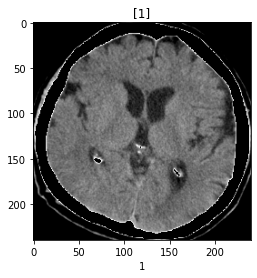

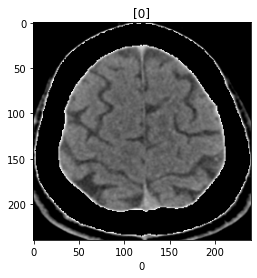

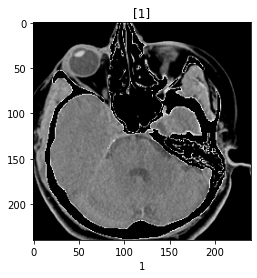

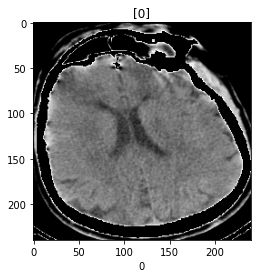

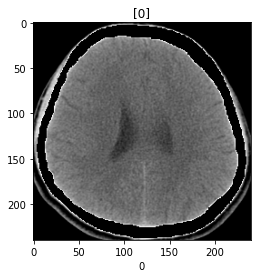

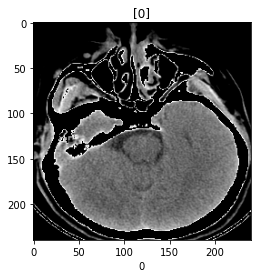

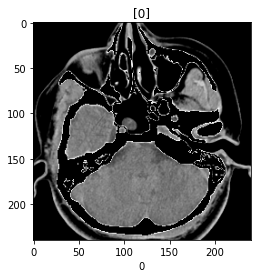

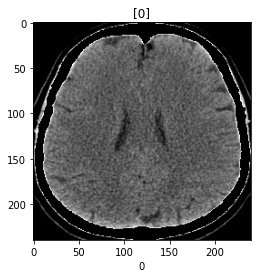

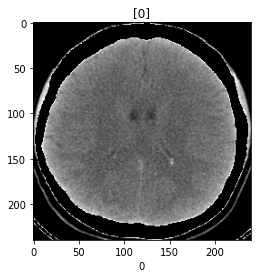

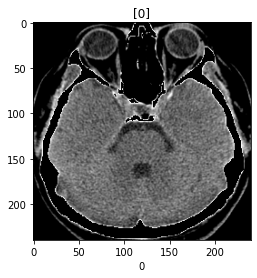

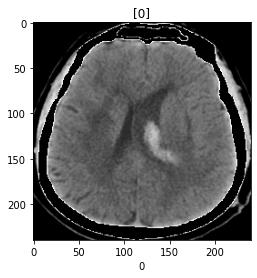

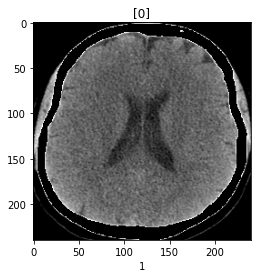

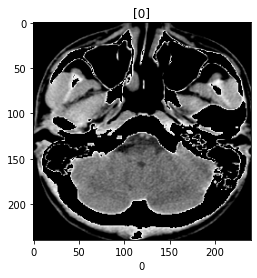

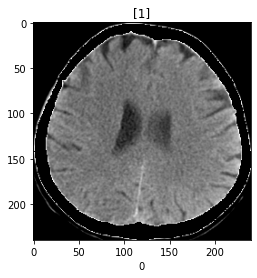

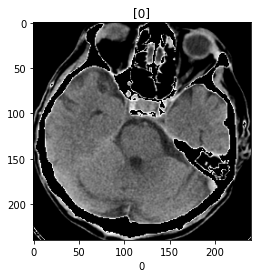

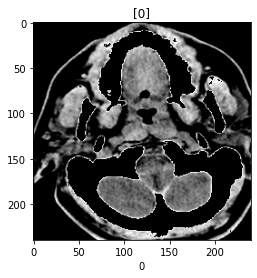

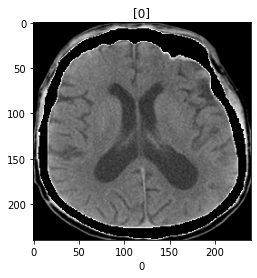

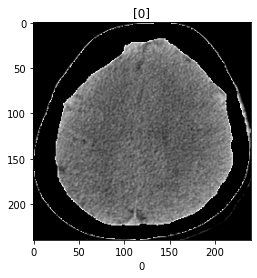

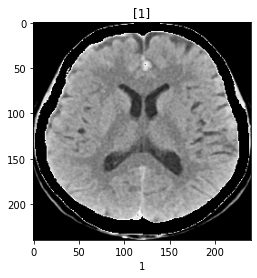

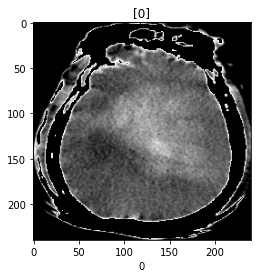

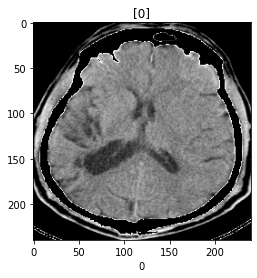

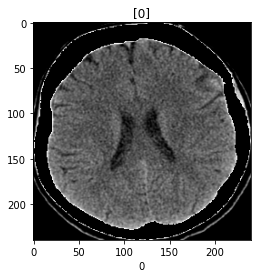

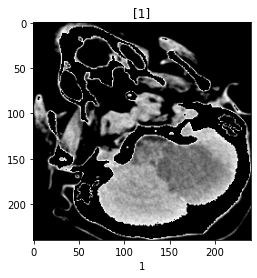

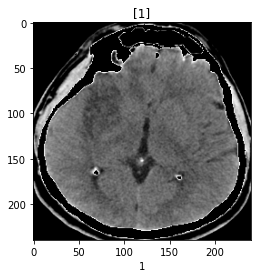

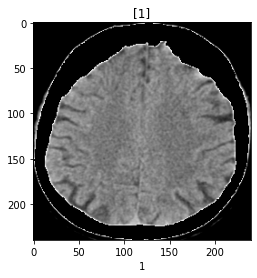

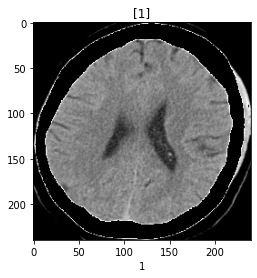

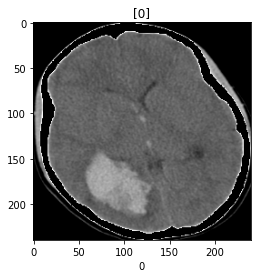

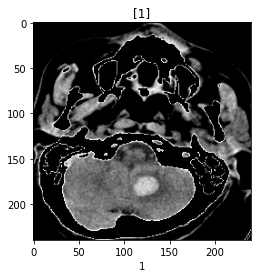

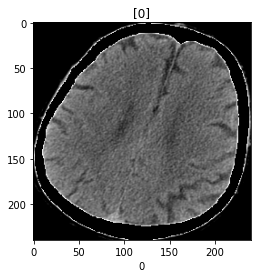

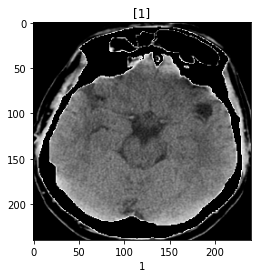

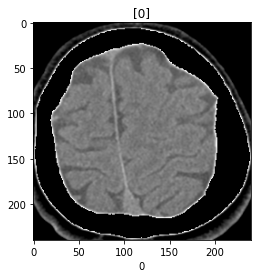

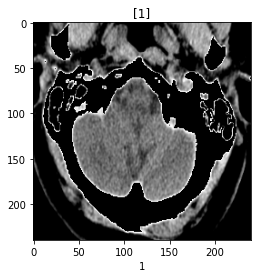

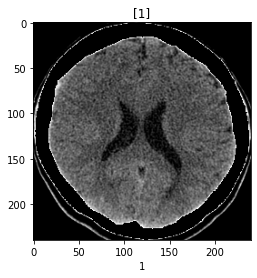

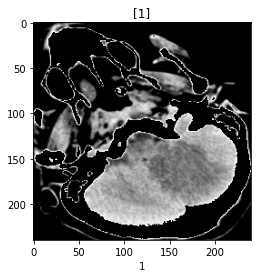

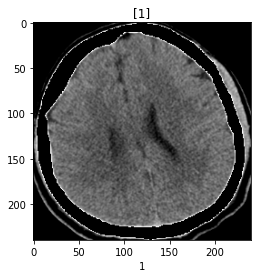

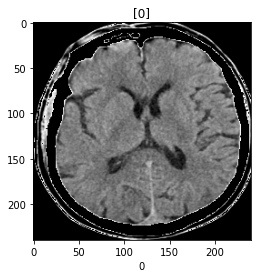

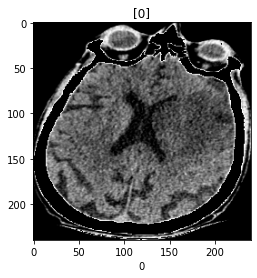

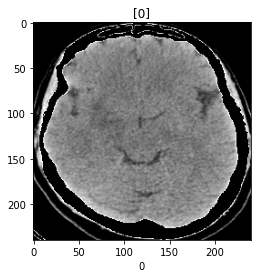

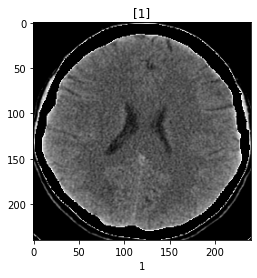

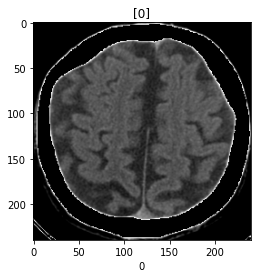

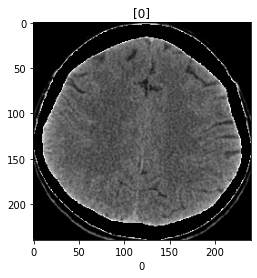

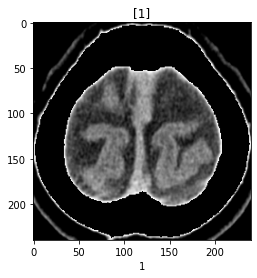

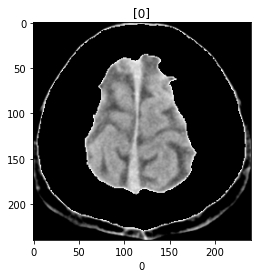

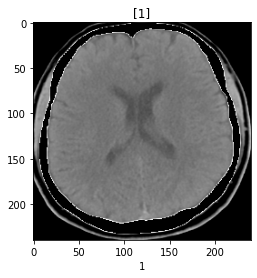

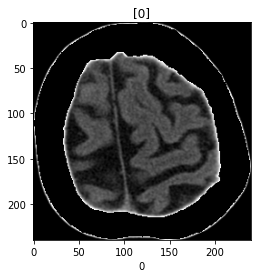

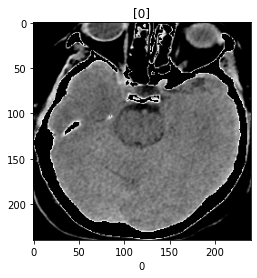

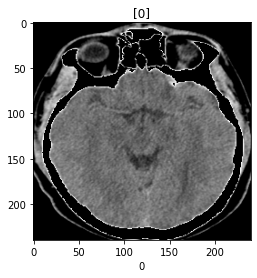

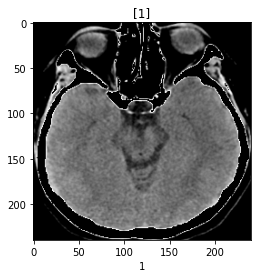

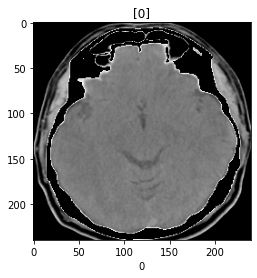

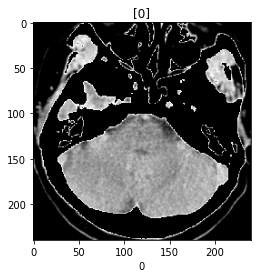

In [ ]:
ynew = modelVGG16.predict_classes(X_test)
count = 0
index = 0
for img in X_test[100:150]:
    
    plt.figure()
    plt.title(ynew[index])
    plt.xlabel(y_test[index])
    plt.imshow(img)
    index = index +1